# 3D Plotting & Testing KMeans
## To run this file:
- Check that you have the imports and the news dataframe
- Prep Data: update the data path and mount your drive (if on colab)
- Run all cells :)

# Imports

In [33]:
# Data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model
from sklearn.cluster import KMeans

# NLP
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Helper functions
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prep Data

In [35]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Cogs 118b/df_labeled.csv'  # Change to where you are keeping the data! (you may need to mount to your drive)
newsdf = pd.read_csv(data_path)

In [36]:
newsdf = newsdf.dropna(subset=['title'])
newsdf = newsdf[newsdf.title != '']

In [37]:
# A function to prepare the dataset, given a list of strings for each feature
# Optional features - compound, pos, neg, neu, num words, num characters
def prep_data(newsdf, feature_list): 
  data = []
  for feature in feature_list:
      data.append(np.array(newsdf.get(feature)))
  formatted_data = np.array(data).T
  return formatted_data

In [38]:
label_feature = 'label'
sentiment_feature = 'compound'
num_words_feature = 'num words'
num_chars_feature = 'num characters'
pos_feature = 'pos'
neg_feature = 'neg'
neu_feature = 'neu'
labels = np.array(newsdf.get('label'))

In [39]:
# Try various combinations of the columns, to check the accuracy on our model
data1 = prep_data(newsdf,[sentiment_feature, num_words_feature, num_chars_feature])    #65% accuracy
data2 = prep_data(newsdf, [pos_feature, num_words_feature, num_chars_feature])         #65% accuracy
data3 = prep_data(newsdf, [pos_feature, neg_feature, num_chars_feature])               #67% accuracy
data4 = prep_data(newsdf, [pos_feature, neg_feature, neu_feature])                     #56% accuracy
data5 = prep_data(newsdf, [neu_feature, neg_feature, pos_feature])                     #56% accuracy
data6 = prep_data(newsdf, [neg_feature, num_words_feature, num_chars_feature])         #65% accuracy
data7 = prep_data(newsdf, [neg_feature, sentiment_feature, num_chars_feature])         #67% accuracy
data8 = prep_data(newsdf, [neg_feature, sentiment_feature, num_words_feature])         #75% accuracy - winner!
#data9 = prep_data(newsdf, [neg_feature, sentiment_feature, avg_word_length_feature])   #59% accuracy
data10 = prep_data(newsdf, [neg_feature, sentiment_feature, pos_feature])   #
bigdata = prep_data(newsdf, [sentiment_feature, pos_feature, neg_feature, neu_feature, num_words_feature, num_chars_feature])

In [40]:
#import natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.probability import FreqDist
import string

# get lexicon 
nltk.download('vader_lexicon') 
nltk.download('punkt')
nltk.download('stopwords')

analyser = SentimentIntensityAnalyzer()

## import word tokenizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', max_features = 2000, tokenizer = word_tokenize, 
                             stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(newsdf['title']).toarray()
# y = np.array(df_labeled['label'])

tfidf = TfidfVectorizer(sublinear_tf = True, analyzer = 'word', max_features = 2000, tokenizer = word_tokenize)
tfidf_X = tfidf.fit_transform(newsdf['title']).toarray()
tfidf_X

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.35842266, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [42]:
tfidf_X.shape

(44889, 2000)

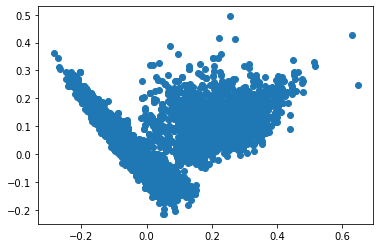

In [43]:
pca = PCA(n_components=300).fit(tfidf_X)
data_pca = pca.transform(tfidf_X)
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.show()

In [44]:
# Add sentiment to TF-IDF and then PCA-TF-IDF Data
tfidf_and_sentiment = np.hstack((tfidf_X, bigdata))
pca_tfidf_and_sentiment = np.hstack((data_pca, bigdata))

# Helper Functions

In [45]:
# A function to plot the real labels in 3d (for comparison to the k-means plot)
def plot_labels(data, labels, angle1=0, angle2=0, title='3d real labels', xlbl='x', ylbl='y', flip=True, dim=[0,1,2]):
    if flip:   #because the groups may be named differently, this variable 'flips' all bits so the colors match
      labels=1-labels
    fig = plt.figure(figsize=(10,10))
    ax0 = fig.add_subplot(projection='3d')
    ax0.scatter(data[:,dim[0]], data[:,dim[1]], data[:,dim[2]], c=labels)
    #ax0.view_init(angle1, angle2)
    ax0.set_title(title) 
    ax0.set_xlabel(xlbl)
    ax0.set_ylabel(ylbl)

In [46]:
# A function to check what % of the labels were grouped correctly - works for 2d and 3d
def check_acc(km_labels, real_labels):
    same_order = np.sum(km_labels == labels) / len(labels)
    # because of the nature of clustering, the actual naming of the two groups doesn't need to match exactly
    diff_order = np.sum(km_labels != labels) / len(labels)
    acc_fraction = max(same_order, diff_order) 
    print('The accuracy fraction is: ',acc_fraction)
    return acc_fraction

# Plotting

## 6D Sentiment Features

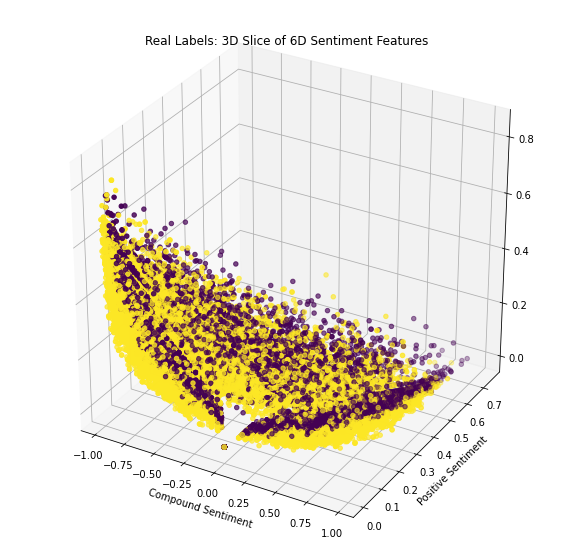

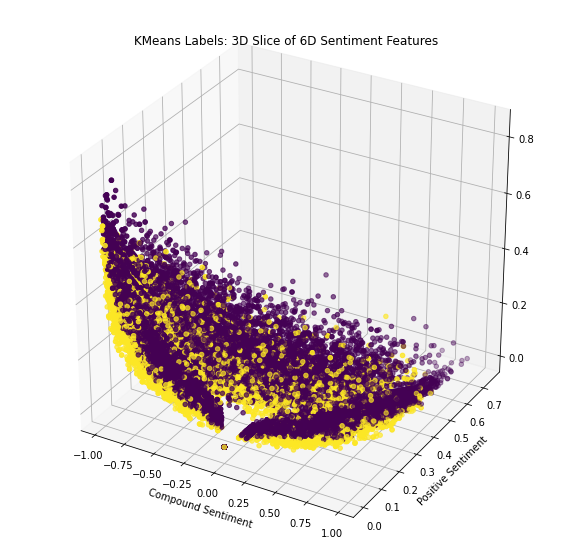

In [47]:
data = bigdata
Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
plot_labels(Xtrain, ytrain, title="Real Labels: 3D Slice of 6D Sentiment Features", xlbl='Compound Sentiment', ylbl='Positive Sentiment')
plt.show()
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plot_labels(Xtrain, km_labels, title="KMeans Labels: 3D Slice of 6D Sentiment Features", xlbl='Compound Sentiment', ylbl='Positive Sentiment', flip=False)
plt.show()

## Shortened Sentiment Feature {Negative Sentiment Score, Compound Sentiment Score, Number of Words}

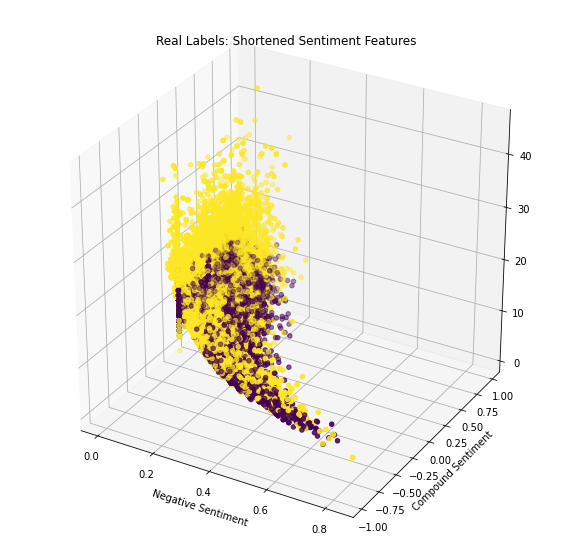

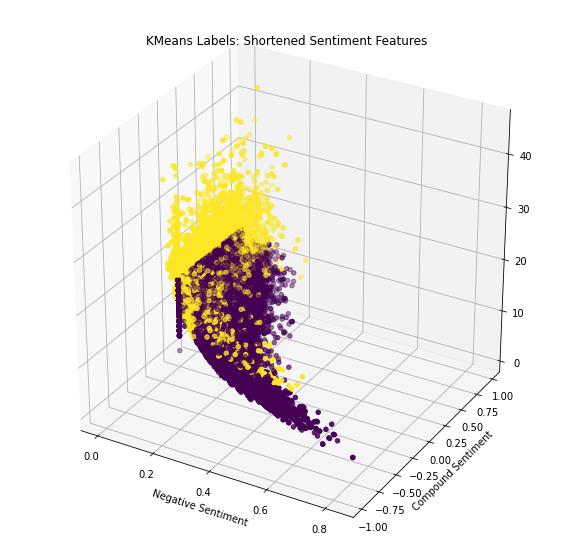

In [48]:
data = data8 # {neg, compound, num_words}
Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
plot_labels(Xtrain, ytrain, title="Real Labels: Shortened Sentiment Features", xlbl='Negative Sentiment', ylbl='Compound Sentiment')
plt.show()
km_labels = KMeans(2, random_state=12).fit(Xtrain).labels_
plot_labels(Xtrain, km_labels, title="KMeans Labels: Shortened Sentiment Features", xlbl='Negative Sentiment', ylbl='Compound Sentiment', flip=False)
plt.show()

## 2000D TF-IDF Data

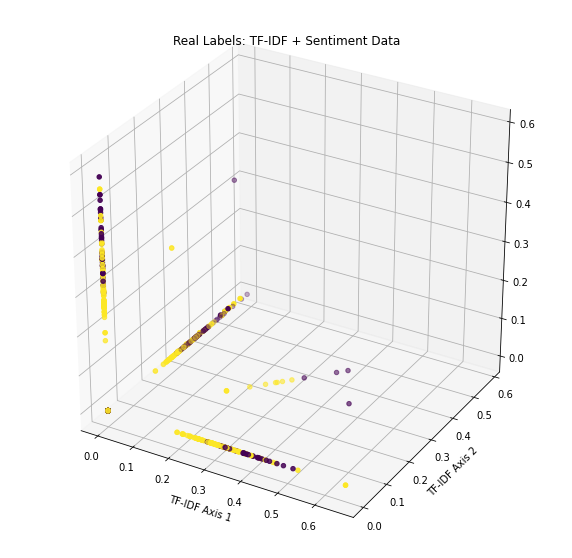

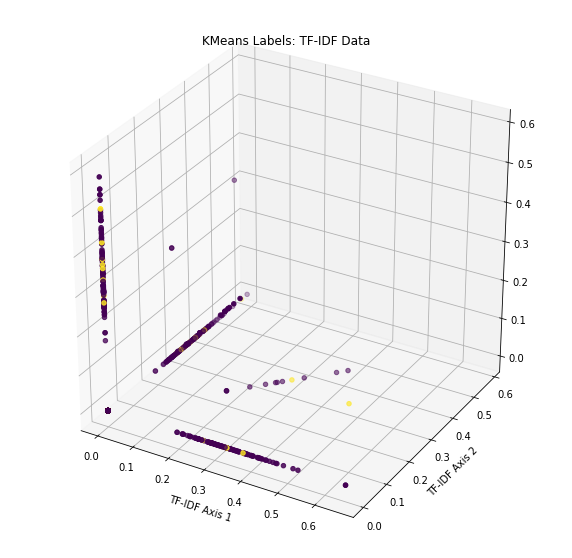

In [49]:
data = tfidf_X
Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
plot_labels(Xtrain,ytrain, title="Real Labels: TF-IDF + Sentiment Data", xlbl='TF-IDF Axis 1', ylbl='TF-IDF Axis 2')
plt.show()
km_labels = KMeans(2, random_state=40).fit(Xtrain).labels_
plot_labels(Xtrain, km_labels, title="KMeans Labels: TF-IDF Data", xlbl='TF-IDF Axis 1', ylbl='TF-IDF Axis 2', flip=False)
plt.show()

## 300D PCA-TF-IDF Data

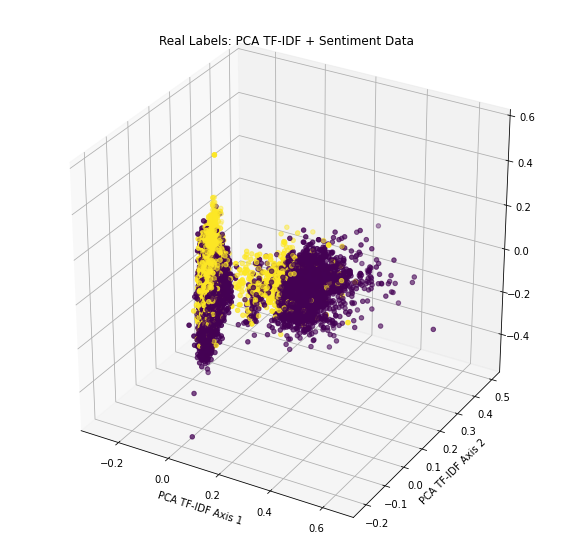

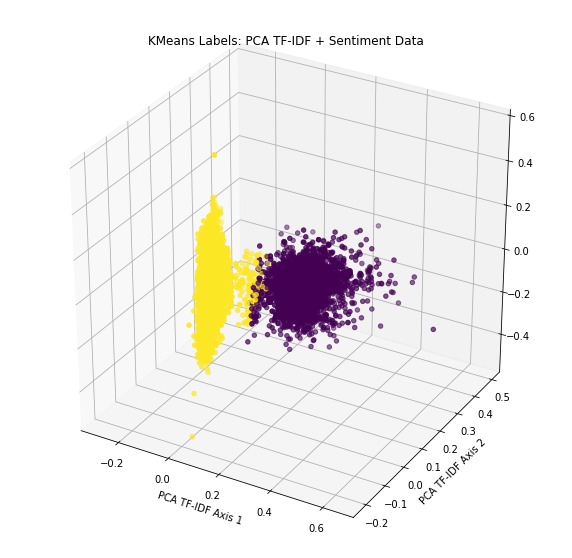

In [50]:
data = data_pca
Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
plot_labels(Xtrain, ytrain, title="Real Labels: PCA TF-IDF + Sentiment Data", xlbl='PCA TF-IDF Axis 1', ylbl='PCA TF-IDF Axis 2')
plt.show()
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plot_labels(Xtrain, km_labels, title="KMeans Labels: PCA TF-IDF + Sentiment Data", xlbl='PCA TF-IDF Axis 1', ylbl='PCA TF-IDF Axis 2', flip=False)
plt.show()

## 2006D TF-IDF + Sentiment Data

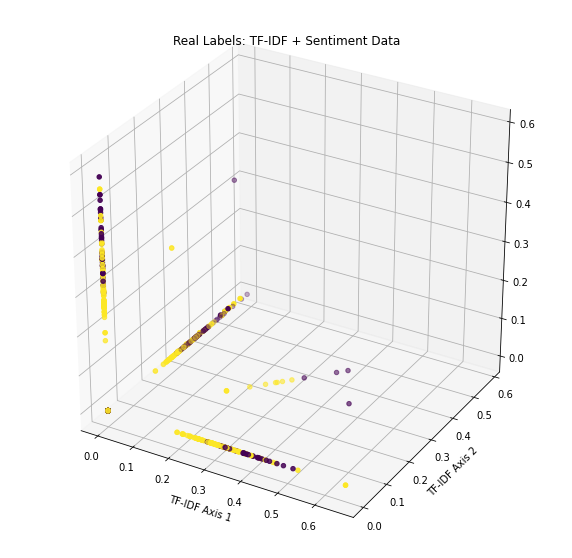

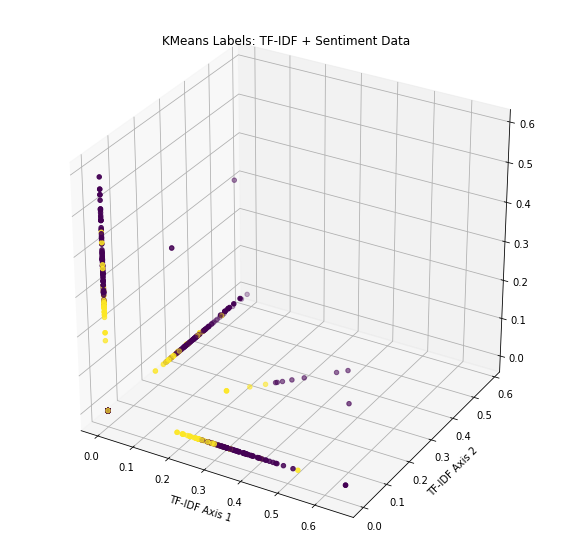

In [51]:
data = tfidf_and_sentiment
Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
plot_labels(Xtrain, ytrain, title="Real Labels: TF-IDF + Sentiment Data", xlbl='TF-IDF Axis 1', ylbl='TF-IDF Axis 2')
plt.show()
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plot_labels(Xtrain, km_labels, title="KMeans Labels: TF-IDF + Sentiment Data", xlbl='TF-IDF Axis 1', ylbl='TF-IDF Axis 2', flip=False)
plt.show()

## 306D PCA-TF-IDF + Sentiment Data

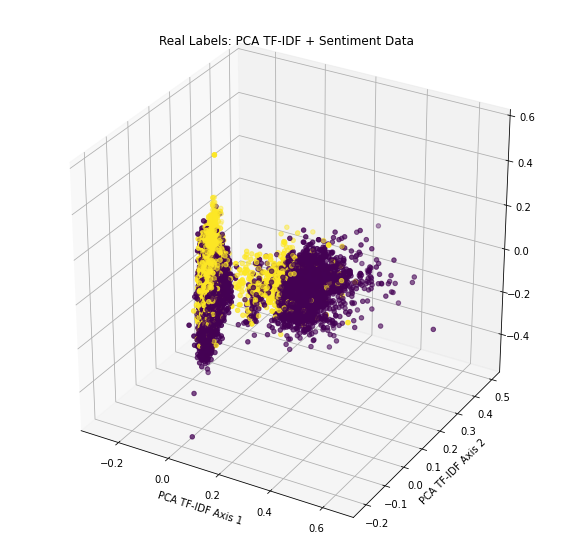

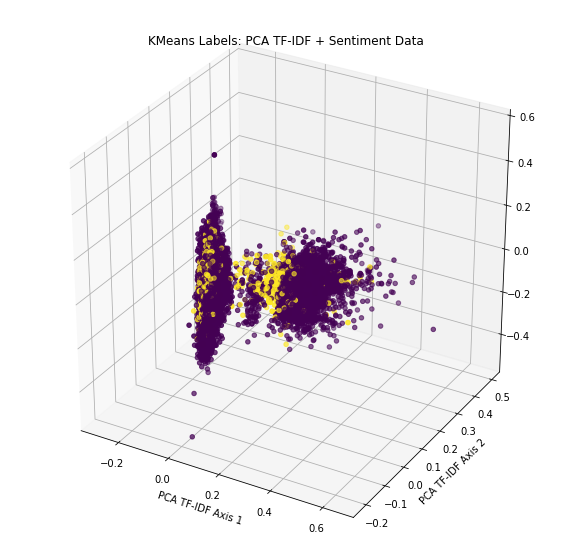

In [52]:
data = pca_tfidf_and_sentiment
Xtrain, Xtest, ytrain, ytest = train_test_split(data, labels, train_size=0.8, random_state=42, shuffle=True)
plot_labels(Xtrain, ytrain, title="Real Labels: PCA TF-IDF + Sentiment Data", xlbl='PCA TF-IDF Axis 1', ylbl='PCA TF-IDF Axis 2')
plt.show()
km_labels = KMeans(2, random_state=0).fit(Xtrain).labels_
plot_labels(Xtrain, km_labels, title="KMeans Labels: PCA TF-IDF + Sentiment Data", xlbl='PCA TF-IDF Axis 1', ylbl='PCA TF-IDF Axis 2', flip=False)
plt.show()